In [21]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
import os
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import torchvision.transforms.functional as F_t

import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import ToPILImage

import torchvision.utils as vutils
import torch.nn.functional as F
import muspy

from midi2audio import FluidSynth
from IPython.display import display, Audio

# Loading the classifier:

In [22]:
class NormalizeSingleChannel(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        if not isinstance(tensor, torch.Tensor):
            raise TypeError(f"img should be Tensor Image. Got {type(tensor)}")

        if tensor.ndim == 3:  # For single-channel input tensor
            tensor = tensor.unsqueeze(0)  # Add batch dimension

        if tensor.ndim != 4 or tensor.shape[1] != 1:
            raise ValueError("Input tensor shape should be [1, H, W]")

        mean = torch.as_tensor(self.mean, dtype=torch.float32, device=tensor.device)
        std = torch.as_tensor(self.std, dtype=torch.float32, device=tensor.device)

        # Broadcast mean and std to match tensor shape
        mean = mean.view(-1, 1, 1)
        std = std.view(-1, 1, 1)

        if self.inplace:
            tensor.sub_(mean).div_(std)
            return tensor
        else:
            return F_t.normalize(tensor, mean, std, self.inplace)

In [23]:
transform = transforms.Compose([
    transforms.Grayscale(),        # Convert images to grayscale
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15), 
    transforms.Resize((224, 224)),   # Resize images to 224x224 (or any appropriate size for your model)
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize images
])

# Load FER2013 dataset
fer2013_df = pd.read_csv('fer2013.csv')

target_emotions = [0, 3, 4]  # 0: anger, 3: happiness, 4: sadness
filtered_df = fer2013_df[fer2013_df['emotion'].isin(target_emotions)] 

# Define a mapping dictionary
mapping = {0: 0, 3: 1, 4: 2}
# Apply the mapping to the dataset labels
filtered_df['emotion'] = filtered_df['emotion'].map(mapping)


In [24]:
# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.to_pil = ToPILImage()  # Instantiate ToPILImage transformer
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.array(self.dataframe.iloc[idx, 1].split(), dtype=np.uint8).reshape(48, 48)
        label = int(self.dataframe.iloc[idx, 0])  # No need to subtract 1 from the label

        # Convert NumPy array to PIL Image
        image = self.to_pil(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# Create custom dataset and apply transformations
custom_dataset = CustomDataset(filtered_df, transform=transform)

In [25]:
# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(custom_dataset))
val_size = int(0.15 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    custom_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [26]:
#Customize the pretrained EfficientNet-B0 model to work on gray scale data, because our dataset Fer2013 is gray scale:
class EfficientNetGray(nn.Module):
    def __init__(self, model_name='efficientnet-b0', num_classes=7):
        super(EfficientNetGray, self).__init__()
        self.model = EfficientNet.from_name(model_name)
        self.model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, bias=False)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Linear(num_ftrs, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.batch_norm = nn.BatchNorm2d(num_ftrs)  # Batch normalization layer

    def forward(self, x):
        x = self.model.extract_features(x)
        x = self.batch_norm(x)  # Batch normalization after the features are extracted
        x = self.model._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.model._dropout(x)
        x = self.model._fc(x)
        return x

In [27]:
# Load the saved classifier model state dictionary
model_classifier = EfficientNetGray()
model_classifier = model_classifier.to(device)
model_classifier.load_state_dict(torch.load('newest_model_efficientnet.pth', map_location=torch.device('cpu')))
model_classifier.eval();

# Loading the GAN

In [28]:
# operations
def batch_norm_2d(x):
    # x_shape = x.shape[1]
    # batch_nor = nn.BatchNorm2d(x_shape, eps=1e-05, momentum=0.9, affine=True)
    # batch_nor = batch_nor
    # output = batch_nor(x)
    output = x
    return output


def batch_norm_1d(x):
    x_shape = x.shape[1]
    # ipdb.set_trace()
    # batch_nor = nn.BatchNorm1d(x_shape, eps=1e-05, momentum=0.9, affine=True)
    # output = batch_nor(x)
    output = x
    return output


def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)


def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])
    return torch.cat((x, y2),1)


def conv_prev_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    #y = y.unsqueeze(0)
    x_shapes = x.shape
    y_shapes = y.shape

    if x_shapes[2:] == y_shapes[2:]:
        y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])
        return torch.cat((x, y2),1)
    else:
        print(x_shapes[2:])
        print(y_shapes[2:])

In [29]:
# generator (4-bar segments)
class sample_generator(nn.Module):
    def __init__(self,pitch_range):
        super(sample_generator, self).__init__()
        self.gf_dim = 64
        self.y_dim = 4
        self.n_channel = 256

        self.h1 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h2 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h3 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h4 = nn.ConvTranspose2d(196, 1, (1,pitch_range), (1,2))

        self.h0_prev = nn.Conv2d(1, 64, (1,pitch_range), (1,2))
        self.h1_prev = nn.Conv2d(64, 64, (2,1), (2,2))
        self.h2_prev = nn.Conv2d(64, 64, (2,1), (2,2))
        self.h3_prev = nn.Conv2d(64, 64, (2,1), (2,2))

        self.linear1 = nn.Linear(404,2048)
        self.linear2 = nn.Linear(2052,self.gf_dim*8*2*1)

    def forward(self, z, prev_x, y ,batch_size=72, pitch_range=128):

        h0_prev = lrelu(batch_norm_2d(self.h0_prev(prev_x)),0.2)   #[72, 64, 64, 1]
        h1_prev = lrelu(batch_norm_2d(self.h1_prev(h0_prev)),0.2)  #[72, 64, 32, 1]
        h2_prev = lrelu(batch_norm_2d(self.h2_prev(h1_prev)),0.2)  #[72, 64, 16, 1]
        h3_prev = lrelu(batch_norm_2d(self.h3_prev(h2_prev)),0.2)  #[72, 64, 8, 1])

        yb = y.view(batch_size,  self.y_dim, 1, 1)  #(72,4,1,1)
        z = torch.cat((z,y),1)         #(72,404)

        h0 = F.relu(batch_norm_1d(self.linear1(z)))    #(72,2048)
        h0 = torch.cat((h0,y),1)   #(72,2052)

        h1 = F.relu(batch_norm_1d(self.linear2(h0)))   #(72, 1024)
        h1 = h1.view(batch_size, self.gf_dim * 2, 8, 1)     #(72,128,8,1)
        h1 = conv_cond_concat(h1,yb) #(72,132,8,1)

        
        h1 = conv_prev_concat(h1,h3_prev)  #(72, 196, 8, 1)

        h2 = F.relu(batch_norm_2d(self.h1(h1)))  #(72, 128, 8, 1)
        h2 = conv_cond_concat(h2,yb) #([72, 132, 8, 1])

        
        h2 = conv_prev_concat(h2,h2_prev)  #([72, 196, 16, 1])

        h3 = F.relu(batch_norm_2d(self.h2(h2)))  #([72, 128, 16, 1]) 
        h3 = conv_cond_concat(h3,yb)  #([72, 132, 16, 1])

        
        h3 = conv_prev_concat(h3,h1_prev) #([72, 196, 32, 1])

        h4 = F.relu(batch_norm_2d(self.h3(h3)))  #([72, 128, 32, 1])
        h4 = conv_cond_concat(h4,yb)  #([72, 132, 32, 1])

        
        h4 = conv_prev_concat(h4,h0_prev) #([72, 196, 64, 1])

        g_x = torch.sigmoid(self.h4(h4)) #([72, 1, 64, 128])

        return g_x

In [30]:
# load melodies with emotion labels
X_te = np.load('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/X_val.npy')
y_te = np.load('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/y_val.npy')

# obtain melody indices for happy,angry,sad,etc.
happy_mask = y_te[:,0] == 1
angry_mask = y_te[:,1] == 1
sad_mask = y_te[:,2] == 1
neutral_mask = y_te[:,3] == 1

happy_indices = np.where(happy_mask)[0]
angry_indices = np.where(angry_mask)[0]
sad_indices = np.where(sad_mask)[0]
neutral_indicies = np.where(neutral_mask)[0]

In [31]:
# Load the saved GAN model state dictionary
netG = sample_generator(128).to(device)
netG.load_state_dict(torch.load('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/netG_epoch_29.pth'))
netG.eval();

In [32]:
# create function to only keep top 'N' notes from tensor. 
def top_N_notes(tensor, N):
    segment = tensor.cpu().detach().numpy().reshape(64, 128)
    transformed_data = np.zeros_like(segment)
    for j in range(segment.shape[0]):
        # Get the indices of the top N values in the row
        top_N_indices = np.argsort(segment[j])[-N:]
        # Set the top N entries to their respective values
        transformed_data[j, top_N_indices] = segment[j, top_N_indices]
    return torch.from_numpy(transformed_data.reshape(1, 1, 64, 128)).to(device)

def generate_music(netG, label, data, n_bars, nz, device):
    song = []
    for bar in range(n_bars):
        z = torch.randn(1, nz, device=device)
        y = label.to(device)
        if bar == 0:
            prev = data.to(device)
            song.append(prev.cpu().detach().numpy())
        else:
            prev = sample
        sample = netG(z, prev, y, 1, 128)
        sample = top_N_notes(sample, 4)
        song.append(sample.cpu().detach().numpy())
    
    music = np.stack(song)
    music = 127 * music.reshape(64 * 4, 128)
    music = music.astype(int)
    music = muspy.from_pianoroll_representation(music, resolution=16)
    return music

***Finally after loading the emotion classifier and the music GAN check points that we had previously trained, we are able to put them together: we pass an image to the classifier, get the emotion classification results (sad, happy, or angry), then map it to an appropriate input for the GAN model, and then generate the corresponding melody to that input. We save the generated audio files in a separate folder.***

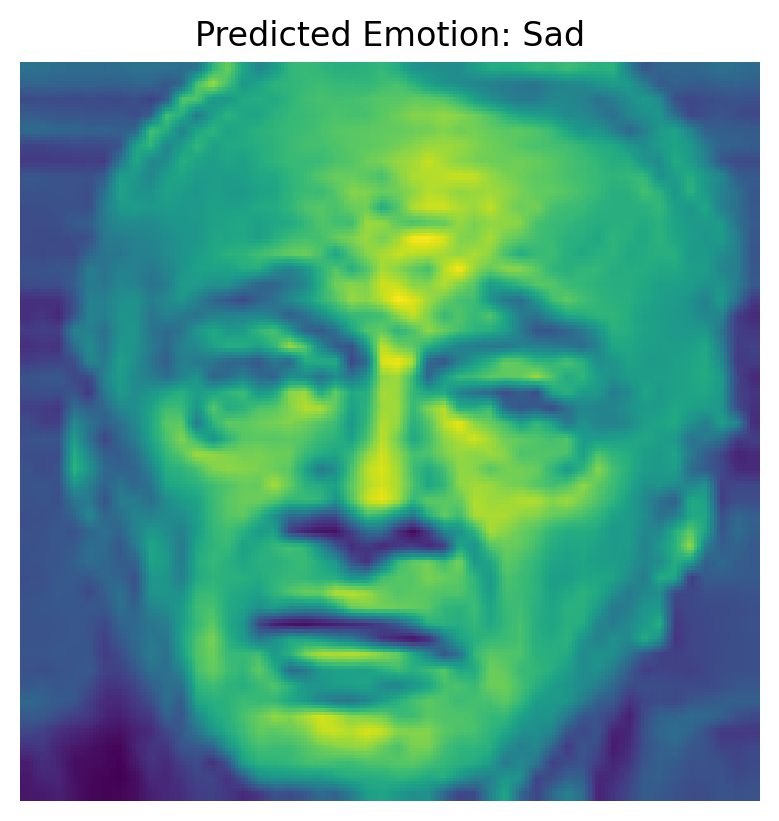

Displaying pianoroll...


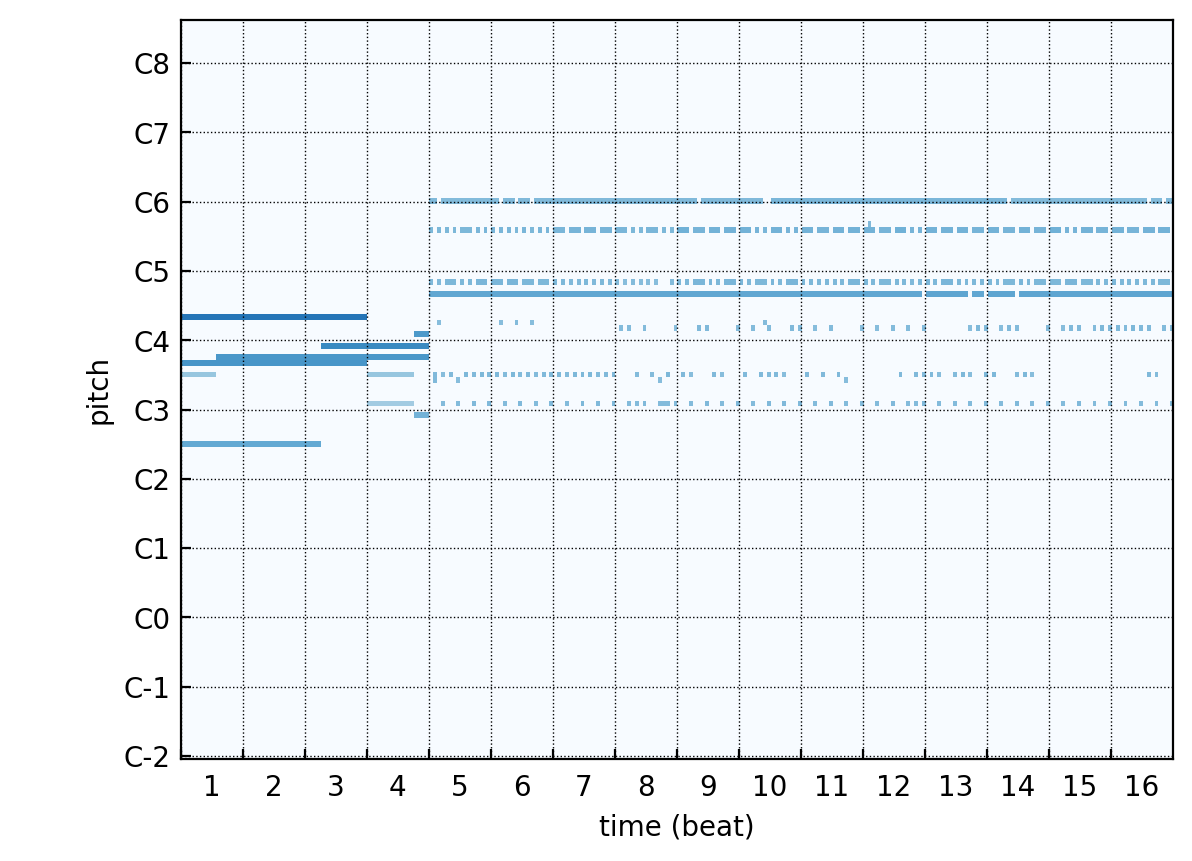

Saving MIDI...


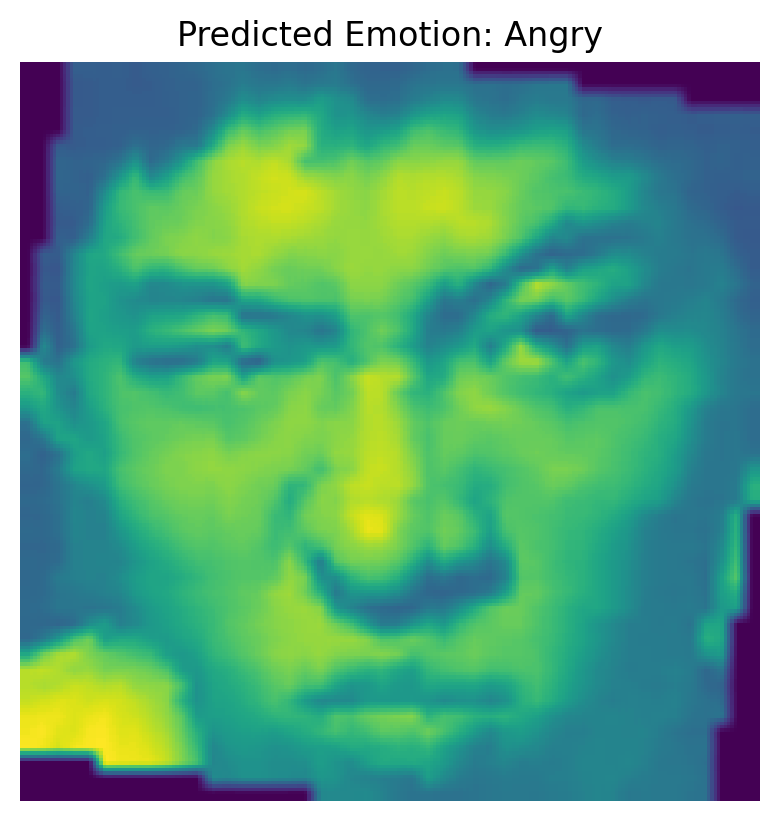

Displaying pianoroll...


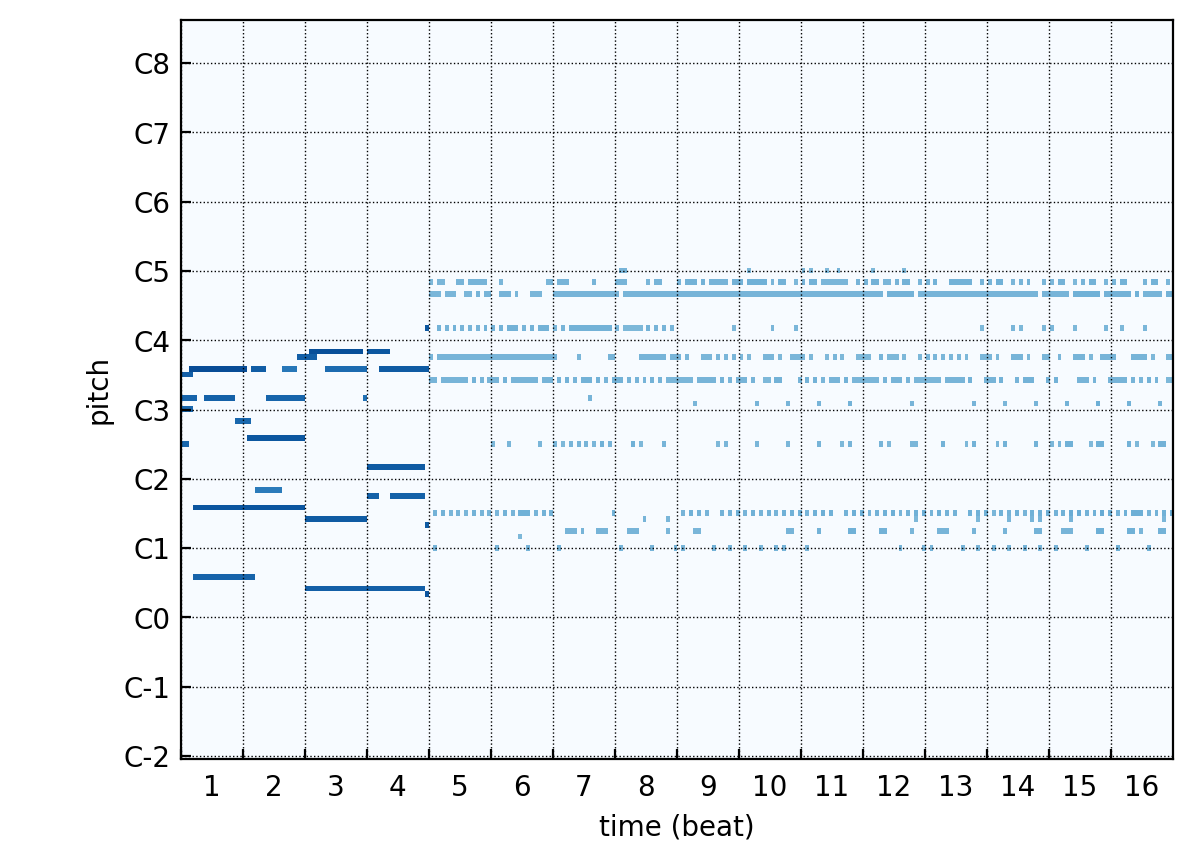

Saving MIDI...


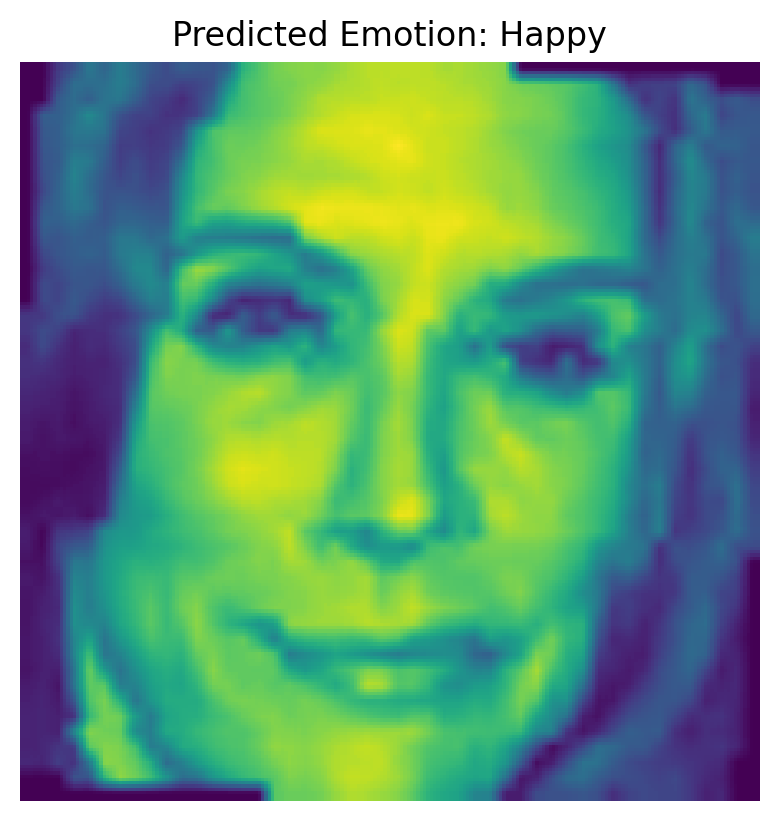

Displaying pianoroll...


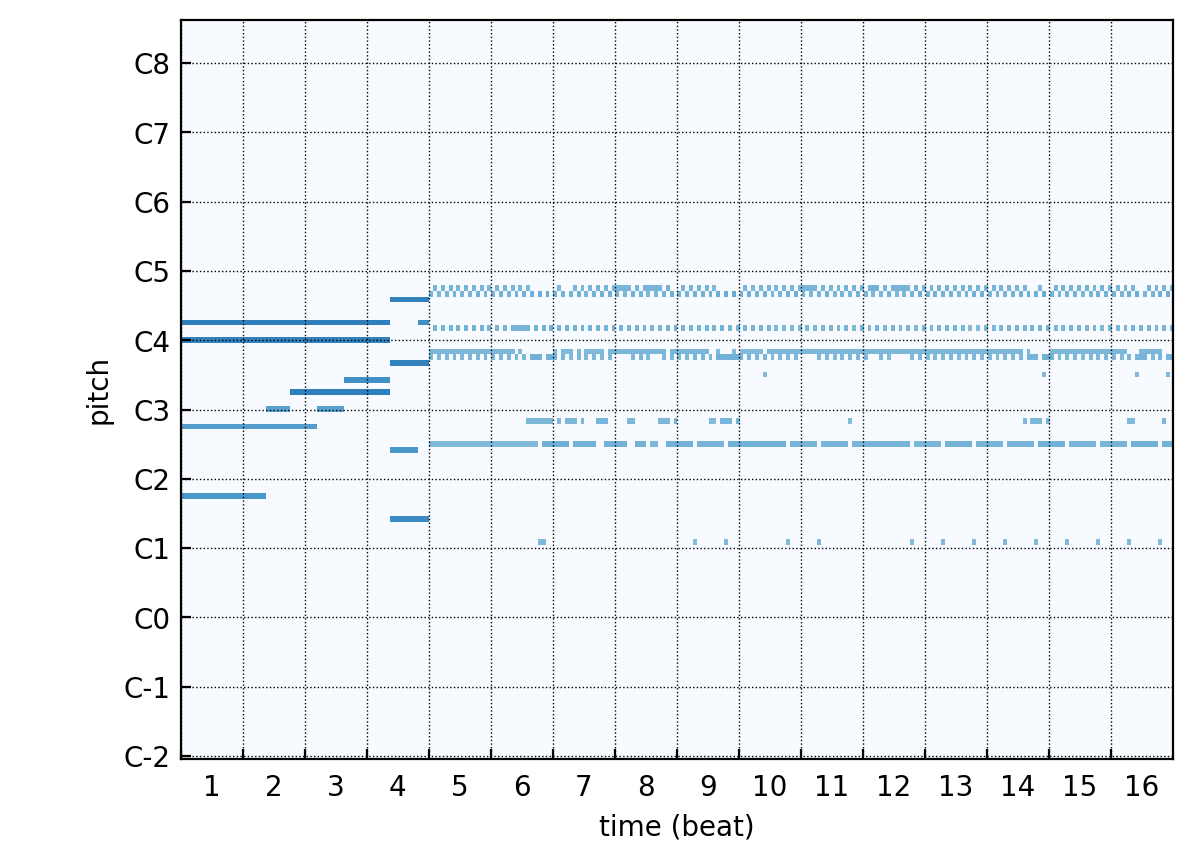

Saving MIDI...


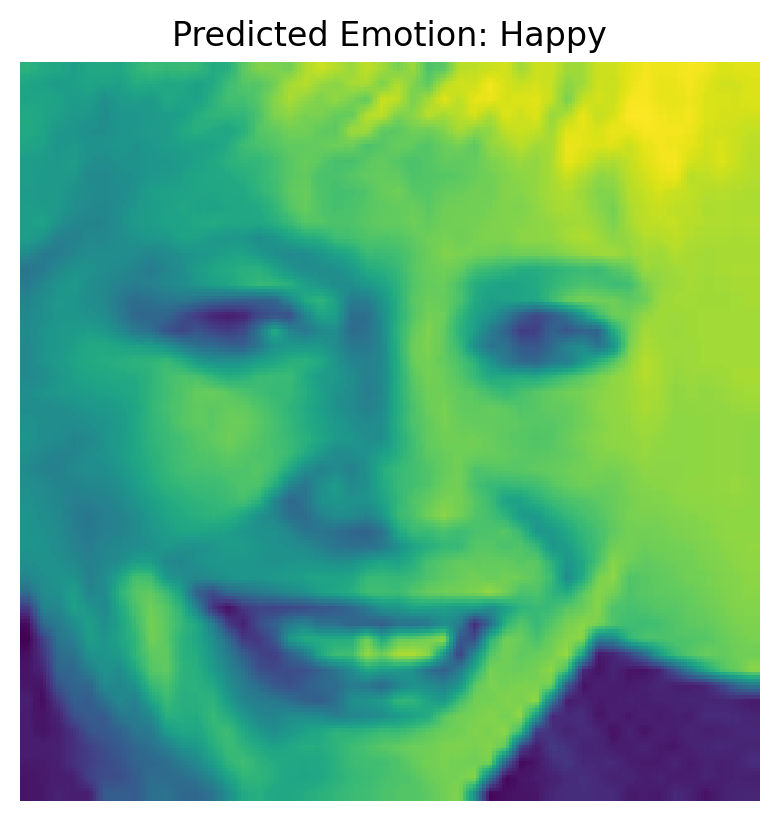

Displaying pianoroll...


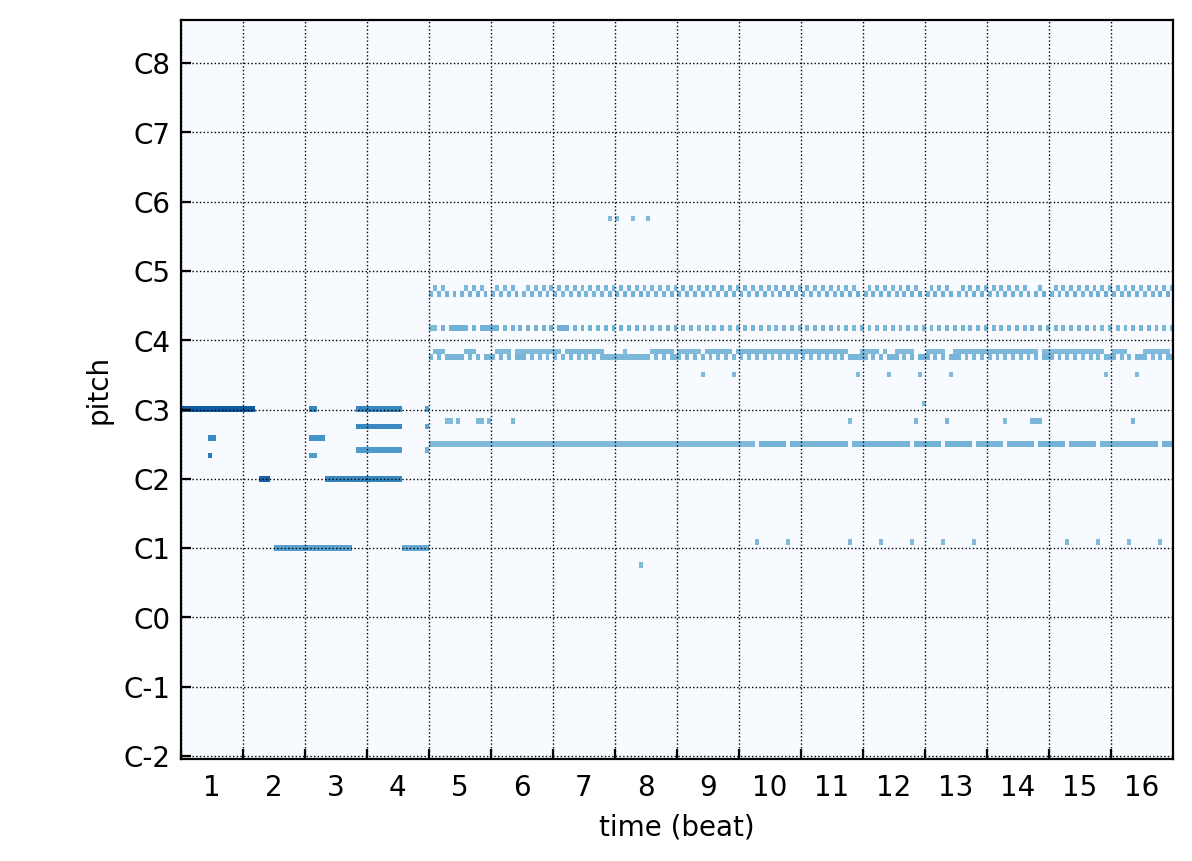

Saving MIDI...


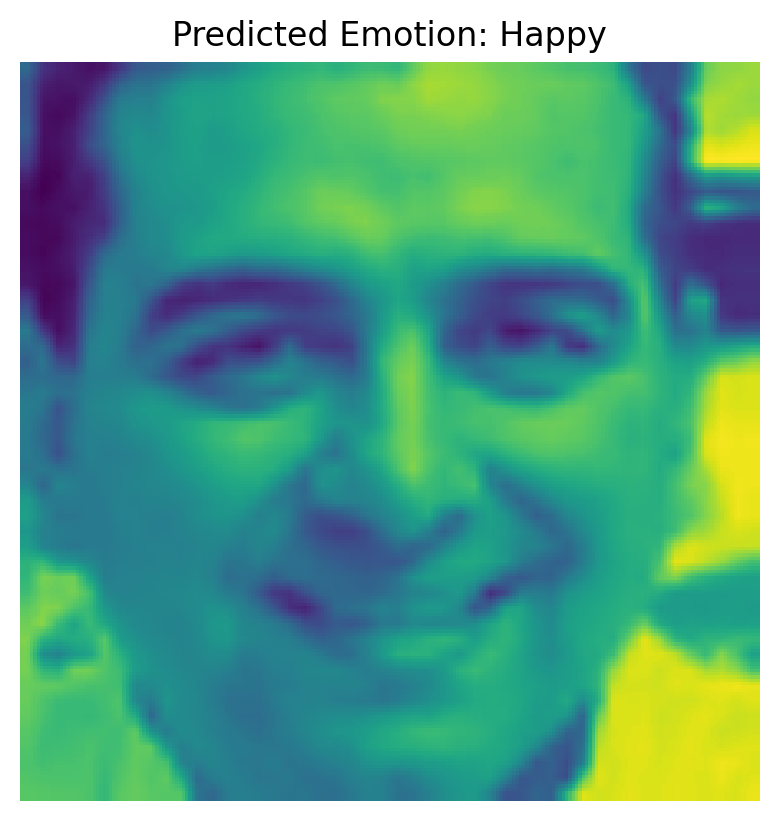

Displaying pianoroll...


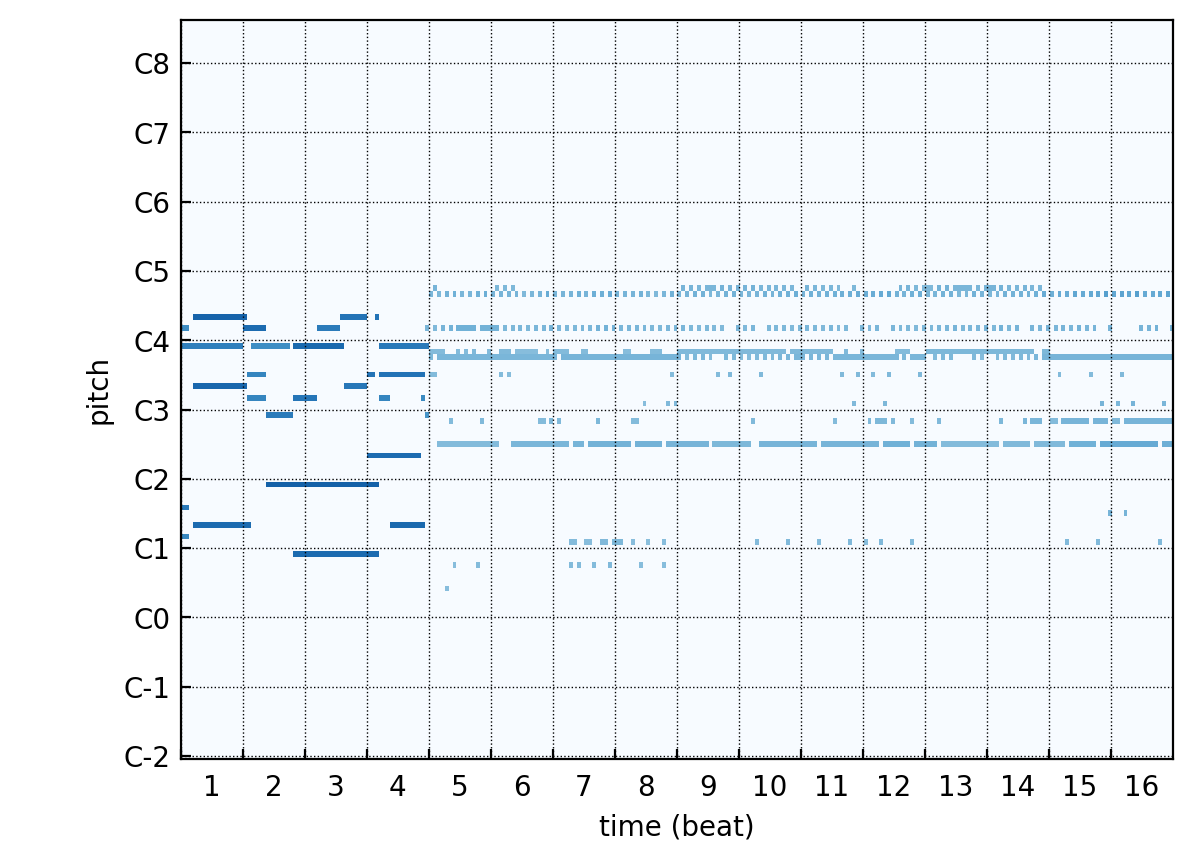

Saving MIDI...


In [34]:
nz = 400   # noise vector
n_bars = 3  # generate next three 4-bar piano rolls

# Define emotion labels
emotion_labels = {0: 'Angry', 3: 'Happy', 4: 'Sad'}

# Function to reverse map numerical labels to original labels
reverse_mapping = {v: k for k, v in mapping.items()}

# Get 5 random samples from the test dataset
num_samples = 5
random_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

save_path = "/scratch/ne2213/projects/DL/DL-FinalProject/FINAL-RESULTS/"

rate = 44100

# Iterate over the random indices
for idx in random_indices:
    image, label = test_dataset[idx]
    
    # Add batch dimension
    image = image.unsqueeze(0)
    
    # Move image to GPU if available
    image = image.to(device)
    
    # Perform inference
    with torch.no_grad():
        output = model_classifier(image)
    
    # Get predicted label
    _, predicted = torch.max(output, 1)
    
    # Reverse map predicted label to original label
    original_label = reverse_mapping[predicted.item()]
    
    # Convert original label to emotion
    predicted_emotion = emotion_labels[original_label]
    
    # Convert image tensor to numpy array
    image_np = image.squeeze(0).cpu().numpy()
    
    # Transpose image array to (height, width, channels)
    image_np = np.transpose(image_np, (1, 2, 0))
    
    # Display the image and predicted emotion
    plt.imshow(image_np)
    plt.title(f'Predicted Emotion: {predicted_emotion}')
    plt.axis('off')
    plt.show()

    # Convert predicted emotion to random melody index
    if predicted_emotion == 'Happy':
        random_index = random.choice(happy_indices)
    elif predicted_emotion == 'Angry':
        random_index = random.choice(angry_indices)
    elif predicted_emotion == 'Sad':
        random_index = random.choice(sad_indices)
    else:
        # Handle unknown emotion
        random_index = random.choice(neutral_indices)

    # obtain random melody and mood label then convert to torch tensor
    data = torch.from_numpy(X_te[random_index,:]).float()
    label = torch.from_numpy(y_te[random_index,:]).float()

    # Generate the music here:
    label = label.unsqueeze(0)
    data = data.unsqueeze(0)
    music = generate_music(netG, label, data, n_bars, nz, device)


    print("Displaying pianoroll...")
    # Display the pianoroll
    muspy.show_pianoroll(music)
    plt.show()

    print("Saving MIDI...")
    # Save the music as MIDI
    filename = f"{predicted_emotion}{idx}.mid" 
    filepath = os.path.join(save_path, filename)  # Combine the path and filename
    music.write(filepath)